# Outlierit

Lukee väliaikaisesti kansiosta datan, yhdistää .csv tiedostot yhteen pandasin dataframeen

Tarkistetaan onko outouksia

## Datasetin nimi pitää muuttaa nimeltään "df"

In [2]:
missing_count = df.isnull().sum()
print(missing_count)

node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64


In [3]:
print("uniques in x",len(df['x'].unique()))
print("uniques in y",len(df['y'].unique()))
print("uniques in z",len(df['z'].unique()))
print("uniques in q",len(df['q'].unique()))

uniques in x 10527
uniques in y 7879
uniques in z 3
uniques in q 1


In [4]:
print("uniques in z",df['z'].unique())
print("uniques in q",df['q'].unique())

uniques in z [100 400   0]
uniques in q [0]


- q eli signaalin laatu ei vaihtele yhtään.
- z eli z-akseli (ylös päin), muuttuu nollasta sataan ja neljäänsataan

In [ ]:
from scipy.stats import zscore
import numpy as np
z = np.abs(zscore(df))
print(z)

### Otetaan käyttöön vain ensimmäinen node

In [5]:
print("Number of nodes: %s" % len(df["node_id"].unique()))

print("First node: %s" % df["node_id"].unique()[0])
node = df["node_id"].unique()[0]

df1 = df[df["node_id"] == node]
df1

Number of nodes: 31
First node: -2393099149039893844


,node_id,timestamp,x,y,z,q
0,-2393099149039893844,2020-06-24 12:20:09.111215+00:00,2827,-230,100,0
1,-2393099149039893844,2020-06-24 12:20:09.622861+00:00,2918,-201,100,0
2,-2393099149039893844,2020-06-24 12:20:09.962124+00:00,2910,-222,100,0
3,-2393099149039893844,2020-06-24 12:20:10.870449+00:00,2925,-102,100,0
4,-2393099149039893844,2020-06-24 12:20:11.234591+00:00,2912,-93,100,0
...,...,...,...,...,...,...
257194,-2393099149039893844,2020-08-14 06:32:14.425895+00:00,1654,-20,100,0
257195,-2393099149039893844,2020-08-14 06:38:19.425952+00:00,1638,-22,100,0
257196,-2393099149039893844,2020-08-14 06:43:59.425925+00:00,1651,-19,100,0
257197,-2393099149039893844,2020-08-14 06:44:07.426025+00:00,1658,-13,100,0


In [6]:
print("x",len(df1["x"].unique()))
print("y",len(df1["y"].unique()))
print("z",len(df1["z"].unique()))
print("q",len(df1["q"].unique()))

x 4166
y 4325
z 1
q 1


In [7]:
from scipy.stats import zscore
import numpy as np
print("x",np.abs(zscore(df1['x'])))
print("y",np.abs(zscore(df1['y'])))

x [1.00687384 1.11231156 1.10304231 ... 0.35570598 0.34759539 0.33600883]
y [0.76496222 0.73668411 0.75716136 ... 0.55921463 0.55336399 0.54751334]


In [8]:
df2 = df1[["x","y"]]
df2.head()

,x,y
0,2827,-230
1,2918,-201
2,2910,-222
3,2925,-102
4,2912,-93


### Poista kaikki rivit, joilla on poikkeavuuksia vähintään yhdessä sarakkeessa

- Jokaiselle sarakkeelle se laskee ensin sarakkeen jokaisen arvon Z-pistemäärän suhteessa sarakkeen keskiarvoon ja keskihajontaan.
- Sitten on Z-pisteiden absoluuttinen arvo, koska suunta ei ole väliä, vain jos se on kynnyksen alapuolella.
- kaikki (akseli = 1) varmistaa, että jokainen rivi, kaikki sarakkeet täyttävät rajoituksen.
- Lopuksi tämän ehdon tulosta käytetään datakehyksen indeksointiin.

In [9]:
from scipy.stats import zscore
import numpy as np
#np.abs(zscore(df1['x']))
df_clean = df2[(np.abs(zscore(df2)) <= 2.5).all(axis=1)]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# pd.concat lisää kaksi DataFrame-kehystä yhteen liittämällä ne peräkkäin.
# jos on päällekkäisyyksiä, se kaapataan drop_duplicates:illa
# drop_duplicates oletusarvoisesti jättää ensimmäisen havainnon ja poistaa kaikki muut havainnot.
# Tässä tapauksessa haluamme, että jokainen kaksoiskappale poistetaan. Siksi keep = False -parametri
potato = pd.concat([df2, df_clean, df_clean]).drop_duplicates(keep=False)

print("Data with outliers: ", len(df2))
print("Ouliers removed:    ", len(df2) - len(potato))
print("Amount of outliers: ",  len(potato))
potato

Data with outliers:  257199
Ouliers removed:     255914
Amount of outliers:  1285


,x,y
41,3178,3132
287,-332,40
1383,3010,3458
1384,2979,3207
1387,2783,3383
...,...,...
253090,283,3124
256139,-231,2475
256140,-290,2468
256141,-257,2418


Huom. toistuvaan df2:een. Vain yhden df2: n avulla mitä tahansa riviä df2: ssa, joka ei ole df1, ei pidetä kaksoiskappaleena ja se säilyy. Tämä ratkaisu, jossa on vain yksi df2, toimii vain, kun df2 on df1: n osajoukko. Jos kuitenkin liitämme df2: n kahdesti, se on taattu kopio ja se poistetaan myöhemmin.

#### Toinen ratkaisu

In [10]:
df_clean = df2[np.abs(df2-df2.mean()) <= (2*df2.std())]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# Sama, mutta toisinpäin
#df2[~(np.abs(df2-df2.mean()) > (3*df2.std()))]

## Plottaus

<function matplotlib.pyplot.show(close=None, block=None)>

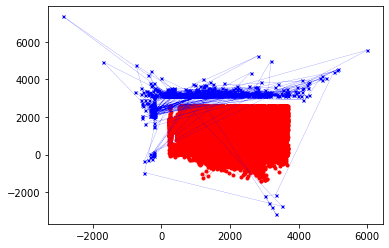

In [11]:
import matplotlib.pyplot as plt

plt.plot(df_clean["x"], df_clean["y"], color="red", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.plot(potato["x"], potato["y"], color="blue", marker='x', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

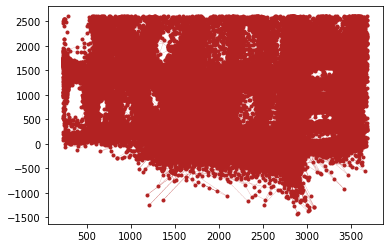

In [12]:
plt.plot(df_clean["x"], df_clean["y"], color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show

In [13]:
test = df2[(np.abs(zscore(df2)) <= 3).all(axis=1)]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# pd.concat lisää kaksi DataFrame-kehystä yhteen liittämällä ne peräkkäin.
# jos on päällekkäisyyksiä, se kaapataan drop_duplicates:illa
# drop_duplicates oletusarvoisesti jättää ensimmäisen havainnon ja poistaa kaikki muut havainnot.
# Tässä tapauksessa haluamme, että jokainen kaksoiskappale poistetaan. Siksi keep = False -parametri
potato = pd.concat([df2, test, test]).drop_duplicates(keep=False)

print("Data with outliers: ", len(df2))
print("Ouliers removed:    ", len(df2) - len(potato))
print("Amount of outliers: ",  len(potato))
potato

Data with outliers:  257199
Ouliers removed:     257158
Amount of outliers:  41


,x,y
3424,1201,4031
4360,2563,3654
4385,1229,3679
4968,5151,4533
4969,4692,4186
7717,4235,3687
7718,4259,3798
7724,2916,3885
7737,1830,3790
8376,4625,4051


x mean:  1957.99870139464
y mean:  554.4904917981796
x std:  863.068702672765
y std:  1025.5284142192352


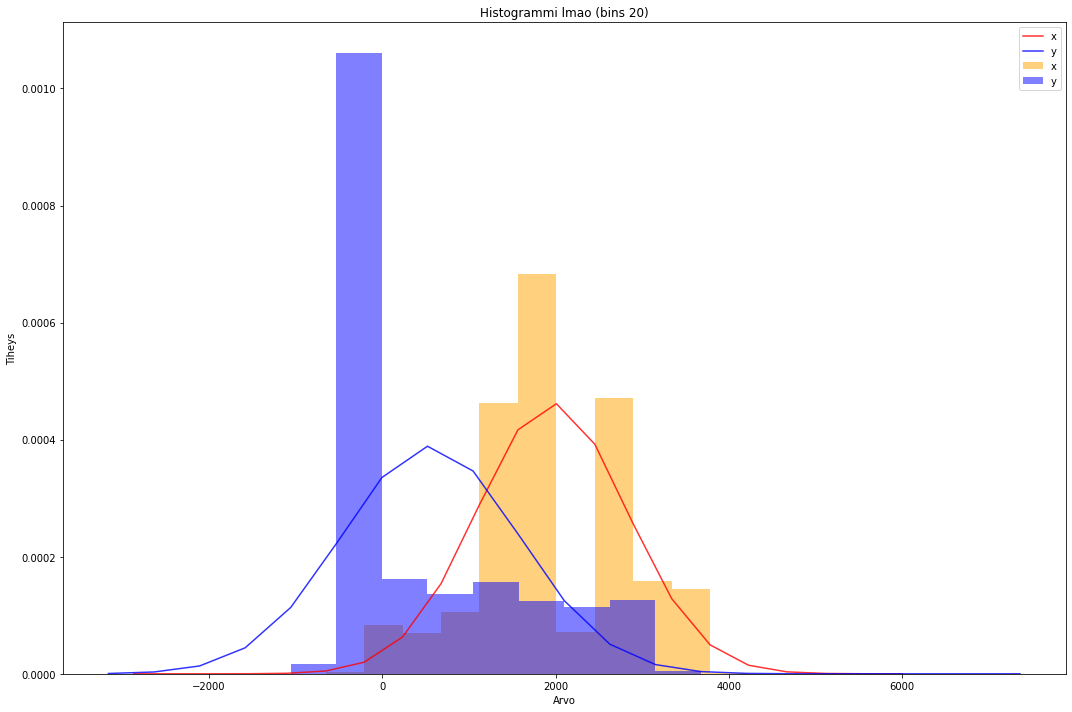

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

def draw_histogram(x, y, bin_num):
    plt.figure(figsize=(15,10))
    # mean of distribution
    mu = np.mean(x)
    mu2 = np.mean(y)
    print("x mean: ", mu)
    print("y mean: ", mu2)

    # standard deviation of distribution
    sigma = np.std(x)
    sigma2 = np.std(y)
    print("x std: ", sigma)
    print("y std: ", sigma2)

    # bins
    num_bins = bin_num

    # the histogram of the data
    n, bins, patches = plt.hist(x, num_bins, density=1, facecolor='orange', alpha=0.5, label='x')
    n2, bins2, patches2 = plt.hist(y, num_bins, density=1, facecolor='blue', alpha=0.5, label='y')

    # add a 'best fit' line
    y = norm.pdf(bins, mu, sigma)
    y2 = norm.pdf(bins2, mu2, sigma2)

    # This is what it norm.pdf does
    #y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    #y2 = ((1 / (np.sqrt(2 * np.pi) * sigma2)) * np.exp(-0.5 * (1 / sigma2 * (bins2 - mu2))**2))

    plt.plot(bins, y, 'r', alpha=0.8, label='x')
    plt.plot(bins2, y2, 'b', alpha=0.8, label='y')

    plt.title("Histogrammi lmao (bins %s)" % num_bins)
    plt.xlabel("Arvo")
    plt.ylabel("Tiheys")
    plt.legend()
    # Tweak spacing to prevent clipping of ylabel
    plt.tight_layout()
    plt.savefig('outliers.jpg')
    plt.show()
    
draw_histogram(df2['x'], df2['y'], 20)

---